# SynthID Text: Watermarking for Generated Text

This notebook demonstrates how to use the [SynthID Text library][synthid-code]
to apply and detect watermarks on generated text. It is divided into three major
sections and intended to be run end-to-end.

1.  **_Setup_**: Importing the SynthID Text library, choosing your model (either
    [Gemma][gemma] or [GPT-2][gpt2]) and device (either CPU or GPU, depending
    on your runtime), defining the watermarking configuration, and initializing
    some helper functions.
1.  **_Applying a watermark_**: Loading your selected model using the
    [Hugging Face Transformers][transformers] library, using that model to
    generate some watermarked text, and comparing the perplexity of the
    watermarked text to that of text generated by the base model.
1.  **_Detecting a watermark_**: Training a detector to recognize text generated
    with a specific watermarking configuration, and then using that detector to
    predict whether a set of examples were generated with that configuration.

As the reference implementation for the
[SynthID Text paper in _Nature_][synthid-paper], this library and notebook are
intended for research review and reproduction only. They should not be used in
production systems. For a production-grade implementation, check out the
official SynthID logits processor in [Hugging Face Transformers][transformers].

[gemma]: https://ai.google.dev/gemma/docs/model_card
[gpt2]: https://huggingface.co/openai-community/gpt2
[synthid-code]: https://github.com/google-deepmind/synthid-text
[synthid-paper]: https://www.nature.com/
[transformers]: https://huggingface.co/docs/transformers/en/index

# 1. Setup

In [1]:
# @title Install and import the required Python packages
#
# @markdown Running this cell may require you to restart your session.

! pip install synthid-text[notebook]

from collections.abc import Sequence
import enum
import gc

import datasets
import huggingface_hub
from synthid_text import detector_mean
from synthid_text import logits_processing
from synthid_text import synthid_mixin
from synthid_text import detector_bayesian
import tensorflow as tf
import torch
import tqdm
import transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
huggingface_hub.notebook_login()

In [4]:
# @title Choose your model.
#
# @markdown This reference implementation is configured to use the Gemma v1.0
# @markdown Instruction-Tuned variants in 2B or 7B sizes, or GPT-2.

class ModelName(enum.Enum):
  GEMMA_2B = 'google/gemma-2b-it'
  GEMMA_7B = 'google/gemma-7b-it'
  MISTRAL_7B = "mistralai/Mistral-7B-Instruct-v0.3"
  LLAMA_8B = "meta-llama/Llama-3.1-8B-Instruct"



model_name = 'mistralai/Mistral-7B-Instruct-v0.3' # @param ['google/gemma-2b-it', 'google/gemma-7b-it', "mistralai/Mistral-7B-Instruct-v0.3", "meta-llama/Llama-3.1-8B-Instruct"]
MODEL_NAME = ModelName(model_name)

In [5]:
# @title Configure your device
#
# @markdown This notebook loads models from Hugging Face Transformers into the
# @markdown PyTorch deep learning runtime. PyTorch supports generation on CPU or
# @markdown GPU, but your chosen model will run best on the following hardware,
# @markdown some of which may require a
# @markdown [Colab Subscription](https://colab.research.google.com/signup).
# @markdown
# @markdown * Gemma v1.0 2B IT: Use a GPU with 16GB of memory, such as a T4.
# @markdown * Gemma v1.0 7B IT: Use a GPU with 32GB of memory, such as an A100.
# @markdown * GPT-2: Any runtime will work, though a High-RAM CPU or any GPU
# @markdown   will be faster.

DEVICE = (
    torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
)
DEVICE

device(type='cuda', index=0)

In [6]:
# @title Example watermarking config
#
# @markdown SynthID Text produces unique watermarks given a configuration, with
# @markdown the most important piece of a configuration being the `keys`: a
# @markdown sequence of unique integers.
# @markdown
# @markdown This reference implementation uses a fixed watermarking
# @markdown configuration, which will be displayed when you run this cell.

CONFIG = synthid_mixin.DEFAULT_WATERMARKING_CONFIG
CONFIG = dict(config)
config['']

immutabledict({'ngram_len': 5, 'keys': [654, 400, 836, 123, 340, 443, 597, 160, 57, 29, 590, 639, 13, 715, 468, 990, 966, 226, 324, 585, 118, 504, 421, 521, 129, 669, 732, 225, 90, 960], 'sampling_table_size': 65536, 'sampling_table_seed': 0, 'context_history_size': 1024, 'device': device(type='cuda', index=0)})

In [10]:
# @title Initialize the required constants, tokenizer, and logits processor

BATCH_SIZE = 10
NUM_BATCHES = 10
OUTPUTS_LEN = 1024
TEMPERATURE = 0.5
TOP_K = 40
TOP_P = 0.99

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME.value)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

logits_processor = logits_processing.SynthIDLogitsProcessor(
    **CONFIG, top_k=TOP_K, temperature=TEMPERATURE
)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [16]:
# @title Utility functions to load models, compute perplexity, and process prompts.

class SynthIDMistralForCausalLM(synthid_mixin.SynthIDSparseTopKMixin, transformers.MistralForCausalLM):
  pass

class SynthIDLlamaForCausalLM(synthid_mixin.SynthIDSparseTopKMixin, transformers.LlamaForCausalLM):
  pass

def load_model(
    model_name: ModelName,
    expected_device: torch.device,
    enable_watermarking: bool = False,
) -> transformers.PreTrainedModel:
  model_cls = (
      SynthIDMistralForCausalLM if enable_watermarking
      else transformers.MistralForCausalLM
  )
  model = model_cls.from_pretrained(
      model_name.value,
      device_map='auto',
      torch_dtype=torch.bfloat16,
  )

  if str(model.device) != str(expected_device):
    raise ValueError('Model device not as expected.')

  return model


def _compute_perplexity(
    outputs: torch.LongTensor,
    scores: torch.FloatTensor,
    eos_token_mask: torch.LongTensor,
    watermarked: bool = False,
) -> float:
  """Compute perplexity given the model outputs and the logits."""
  len_offset = len(scores)
  if watermarked:
    nll_scores = scores
  else:
    nll_scores = [
        torch.gather(
            -torch.log(torch.nn.Softmax(dim=1)(sc)),
            1,
            outputs[:, -len_offset + idx, None],
        )
        for idx, sc in enumerate(scores)
    ]
  nll_sum = torch.nan_to_num(
      torch.squeeze(torch.stack(nll_scores, dim=1), dim=2)
      * eos_token_mask.long(),
      posinf=0,
  )
  nll_sum = nll_sum.sum(dim=1)
  nll_mean = nll_sum / eos_token_mask.sum(dim=1)
  return nll_mean.sum(dim=0)


def _process_raw_prompt(prompt: Sequence[str]) -> str:
  """Add chat template to the raw prompt."""
  return tokenizer.apply_chat_template(
      [{'role': 'user', 'content': prompt.decode().strip('"')}],
      tokenize=False,
      add_generation_prompt=True,
  )

# 2. Applying a watermark

In [ ]:
# @title Generate watermarked output

gc.collect()
torch.cuda.empty_cache()

batch_size = 1
example_inputs = [
    'I enjoy walking with my cute dog',
    'I am from New York',
    'The test was not so very hard after all',
    "I don't think they can score twice in so short a time",
]
example_inputs = example_inputs * (int(batch_size / 4) + 1)
example_inputs = example_inputs[:batch_size]

inputs = tokenizer(
    example_inputs,
    return_tensors='pt',
    padding=True,
).to(DEVICE)

model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)
outputs = model.generate(
    **inputs,
    do_sample=True,
    temperature=0.7,
    max_length=1024,
    top_k=40,
)

print('Output:\n' + 100 * '-')
for i, output in enumerate(outputs):
  print(tokenizer.decode(output, skip_special_tokens=True))
  print(100 * '-')

del inputs, outputs, model
gc.collect()
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, and we have a nice routine. However, lately, I've been feeling fatigued and need to take breaks more often.

I'm not sure if it's the weather or my training routine, but I'm finding it increasingly difficult to maintain my usual pace and stamina. I'm also noticing that my dog seems to be gaining weight and becoming panting more frequently.

I'm not sure how to address this, but I know I need to do something to improve my health and well-being. What steps can I take to maintain my physical fitness and enjoy our walks more?

**1. Assess Your Physical Fitness**

- Check your overall fitness level with a medical professional.
- Take a fitness assessment to determine your baseline fitness level and identify areas for improvement.

**2. Adjust Your Training Routine**

- Take breaks more frequently and shorten your walks if necessary.
- Consider slower

## [Optional] Compare perplexity between watermarked and non-watermarked text

Sample [eli5 dataset](https://facebookresearch.github.io/ELI5/) outputs from
watermarked and non-watermarked models and verify that:

* The [perplexity](https://huggingface.co/docs/transformers/en/perplexity) of
  watermarked and non-watermarked text is similar.

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

In [ ]:
# @title Load Eli5 dataset with HuggingFace datasets.

eli5_prompts = datasets.load_dataset("Pavithree/eli5")

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
# @title Non-watermarked output - perplexity
gc.collect()
torch.cuda.empty_cache()

model = load_model(MODEL_NAME, expected_device=DEVICE)
torch.manual_seed(0)

nonwm_g_values = []
nonwm_eos_masks = []
nonwm_outputs = []
perplexities = []

for batch_id in tqdm.tqdm(range(NUM_BATCHES)):
  prompts = eli5_prompts['train']['title'][
      batch_id * BATCH_SIZE:(batch_id + 1) * BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
      return_dict_in_generate=True,
      output_scores=True,
  )

  scores = outputs.scores
  outputs = outputs.sequences
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs[:, inputs_len:],
      eos_token_id=tokenizer.eos_token_id,
  )

  perplexities.append(_compute_perplexity(outputs, scores, eos_token_mask))

  g_values = logits_processor.compute_g_values(
      input_ids=outputs[:, inputs_len:],
  )

  nonwm_g_values.append(g_values.cpu())
  nonwm_eos_masks.append(eos_token_mask.cpu())
  nonwm_outputs.append(outputs.cpu())

  del inputs, prompts, eos_token_mask, g_values, outputs

del model, nonwm_g_values, nonwm_eos_masks, nonwm_outputs
gc.collect()
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 578.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 316.81 MiB is free. Process 67567 has 39.25 GiB memory in use. Of the allocated memory 8.95 GiB is allocated by PyTorch, and 127.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
final_perplexity = torch.exp(np.sum(perplexities) / (BATCH_SIZE * NUM_BATCHES))
print(f"Perplexity of unwatermarked model: {final_perplexity}")

In [ ]:
# @title Watermarked output - perplexity
gc.collect()
torch.cuda.empty_cache()

model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)

wm_outputs = []
wm_g_values = []
wm_eos_masks = []
perplexities = []

for batch_id in tqdm.tqdm(range(NUM_BATCHES)):
  prompts = eli5_prompts['train']['title'][
      batch_id * BATCH_SIZE:(batch_id + 1) * BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
      return_dict_in_generate=True,
      output_scores=True,
  )
  scores = outputs.scores
  outputs = outputs.sequences

  # Mask to ignore all tokens after the end-of-sequence token.
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs[:, inputs_len:],
      eos_token_id=tokenizer.eos_token_id,
  )

  perplexities.append(_compute_perplexity(outputs, scores, eos_token_mask, watermarked=True))

  g_values = logits_processor.compute_g_values(
      input_ids=outputs[:, inputs_len:],
  )
  wm_outputs.append(outputs.cpu())
  wm_g_values.append(g_values.cpu())
  wm_eos_masks.append(eos_token_mask.cpu())

  del outputs, scores, inputs, prompts, eos_token_mask, g_values

del model, wm_outputs, wm_g_values, wm_eos_masks
gc.collect()
torch.cuda.empty_cache()

In [ ]:
final_perplexity = torch.exp(
    torch.Tensor(np.sum(perplexities)) / (BATCH_SIZE * NUM_BATCHES)
)
print(f"Perplexity of watermarked model: {final_perplexity}")

# 3. Detecting a watermark

To detect the watermark, you have two options:
1.   Use the simple **Mean** scoring function. This can be done quickly and requires no training.
2.   Use the more powerful **Bayesian** scoring function. This requires training and takes more time.

For full explanation of these scoring functions, see the paper and its Supplementary Materials.


In [ ]:
# @title Constants

# NUM_NEGATIVES = 10000
# POS_BATCH_SIZE = 32
# NUM_POS_BATCHES = 313
# NEG_BATCH_SIZE = 32
# # Truncate outputs to this length for training.
# POS_TRUNCATION_LENGTH = 200
# NEG_TRUNCATION_LENGTH = 200
# # Pad trucated outputs to this length for equal shape across all batches.
# MAX_PADDED_LENGTH = 1000
# TEMPERATURE = 1.0

In [ ]:
# @title Generate model responses and compute g-values


def generate_responses(example_inputs, enable_watermarking):
  inputs = tokenizer(
      example_inputs,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)

  # @title Watermarked output preparation for detector training
  gc.collect()
  torch.cuda.empty_cache()

  model = load_model(
      MODEL_NAME,
      expected_device=DEVICE,
      enable_watermarking=enable_watermarking,
  )
  torch.manual_seed(0)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
  )

  outputs = outputs[:, inputs_len:]

  # eos mask is computed, skip first ngram_len - 1 tokens
  # eos_mask will be of shape [batch_size, output_len]
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs,
      eos_token_id=tokenizer.eos_token_id,
  )[:, CONFIG['ngram_len'] - 1 :]

  # context repetition mask is computed
  context_repetition_mask = logits_processor.compute_context_repetition_mask(
      input_ids=outputs,
  )
  # context repitition mask shape [batch_size, output_len - (ngram_len - 1)]

  combined_mask = context_repetition_mask * eos_token_mask

  g_values = logits_processor.compute_g_values(
      input_ids=outputs,
  )
  # g values shape [batch_size, output_len - (ngram_len - 1), depth]

  return g_values, combined_mask


example_inputs = [
    'I enjoy walking with my cute dog',
    'I am from New York',
    'The test was not so very hard after all',
    "I don't think they can score twice in so short a time",
]

wm_g_values, wm_mask = generate_responses(
    example_inputs, enable_watermarking=True
)
uwm_g_values, uwm_mask = generate_responses(
    example_inputs, enable_watermarking=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Option 1: Mean detector

In [ ]:
# @title Get Mean detector scores for the generated outputs.

# Watermarked responses tend to have higher Mean scores than unwatermarked
# responses. To classify responses you can set a score threshold, but this will
# depend on the distribution of scores for your use-case and your desired false
# positive / false negative rates.

wm_mean_scores = detector_mean.mean_score(
    wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
)
uwm_mean_scores = detector_mean.mean_score(
    uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
)

print('Mean scores for watermarked responses: ', wm_mean_scores)
print('Mean scores for unwatermarked responses: ', uwm_mean_scores)

# You may find that the Weighted Mean scoring function gives better
# classification performance than the Mean scoring function (in particular,
# higher scores for watermarked responses). See the paper for full details.

wm_weighted_mean_scores = detector_mean.weighted_mean_score(
    wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
)
uwm_weighted_mean_scores = detector_mean.weighted_mean_score(
    uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
)

print(
    'Weighted Mean scores for watermarked responses: ', wm_weighted_mean_scores
)
print(
    'Weighted Mean scores for unwatermarked responses: ',
    uwm_weighted_mean_scores,
)

Mean scores for watermarked responses:  [0.55022836 0.5505519  0.5565766  0.53449476]
Mean scores for unwatermarked responses:  [0.49746928 0.49824563 0.4886525  0.50691825]
Weighted Mean scores for watermarked responses:  [0.56168956 0.5545502  0.5736518  0.5467368 ]
Weighted Mean scores for unwatermarked responses:  [0.49518034 0.49875242 0.47690696 0.5044872 ]


## Option 2: Bayesian detector

In [ ]:
# @title Generate watermarked samples for training Bayesian detector

gc.collect()
torch.cuda.empty_cache()

model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)

eli5_prompts = datasets.load_dataset("Pavithree/eli5")

wm_outputs = []

for batch_id in tqdm.tqdm(range(NUM_POS_BATCHES)):
  prompts = eli5_prompts['train']['title'][
      batch_id * POS_BATCH_SIZE:(batch_id + 1) * POS_BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
  )

  wm_outputs.append(outputs[:, inputs_len:])

  del outputs, inputs, prompts

del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# @title Generate unwatermarked samples for training Bayesian detector

dataset, info = tfds.load('wikipedia/20230601.en', split='train', with_info=True)

dataset = dataset.take(10000)

# Convert the dataset to a DataFrame
df = tfds.as_dataframe(dataset, info)
ds = tf.data.Dataset.from_tensor_slices(dict(df))
tf.random.set_seed(0)
ds = ds.shuffle(buffer_size=10_000)
ds = ds.batch(batch_size=1)

tokenized_uwm_outputs = []
lengths = []
batched = []
# Pad to this length (on the right) for batching.
padded_length = 2500
for i, batch in tqdm.tqdm(enumerate(ds)):
  responses = [val.decode() for val in batch['text'].numpy()]
  inputs = tokenizer(
      responses,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  line = inputs['input_ids'].cpu().numpy()[0].tolist()
  if len(line) >= padded_length:
    line = line[:padded_length]
  else:
    line = line + [
        tokenizer.eos_token_id for _ in range(padded_length - len(line))
    ]
  batched.append(torch.tensor(line, dtype=torch.long, device=DEVICE)[None, :])
  if len(batched) == NEG_BATCH_SIZE:
    tokenized_uwm_outputs.append(torch.cat(batched, dim=0))
    batched = []
  if i > NUM_NEGATIVES:
    break

In [ ]:
# @title Train the Bayesian detector
bayesian_detector, test_loss = (
    detector_bayesian.BayesianDetector.train_best_detector(
        tokenized_wm_outputs=wm_outputs,
        tokenized_uwm_outputs=tokenized_uwm_outputs,
        logits_processor=logits_processor,
        tokenizer=tokenizer,
        torch_device=DEVICE,
        max_padded_length=MAX_PADDED_LENGTH,
        pos_truncation_length=POS_TRUNCATION_LENGTH,
        neg_truncation_length=NEG_TRUNCATION_LENGTH,
        verbose=True,
        learning_rate=3e-3,
        n_epochs=100,
        l2_weights=np.zeros((1,)),
    )
)

In [ ]:
# @title Get Bayesian detector scores for the generated outputs.

# Watermarked responses tend to have higher Bayesian scores than unwatermarked
# responses. To classify responses you can set a score threshold, but this will
# depend on the distribution of scores for your use-case and your desired false
# positive / false negative rates. See the paper for full details.

wm_bayesian_scores = bayesian_detector.score(
    wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
)
uwm_bayesian_scores = bayesian_detector.score(
    uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
)

print('Bayesian scores for watermarked responses: ', wm_bayesian_scores)
print('Bayesian scores for unwatermarked responses: ', uwm_bayesian_scores)

# **Frequentist Score**

In [12]:
from typing import Optional
import jax.numpy as jnp
from scipy.stats import binom, norm

def frequentist_score(
    g_values: jnp.ndarray,
    mask: jnp.ndarray,
) -> jnp.ndarray:
  """Computes the Frequentist score.

  Args:
    g_values: g-values of shape [batch_size, seq_len, watermarking_depth].
    mask: A binary array shape [batch_size, seq_len] indicating which g-values
      should be used. g-values with mask value 0 are discarded.

  Returns:
    Mean scores, of shape [batch_size]. This is the mean of the unmasked
      g-values.
  """
  watermarking_depth = g_values.shape[-1]
  num_unmasked = jnp.sum(mask, axis=1)  # shape [batch_size]

  sum = jnp.sum(g_values * jnp.expand_dims(mask, 2), axis=(1, 2))
  max_sum = watermarking_depth * num_unmasked

  p_value = 1 - binom.cdf(sum - 1, n=max_sum, p=0.5)

  return -p_value


def weighted_frequentist_score(
    g_values: jnp.ndarray,
    mask: jnp.ndarray,
    weights: Optional[jnp.ndarray] = None,
) -> jnp.ndarray:
  """Computes the Weighted Mean score.

  Args:
    g_values: g-values of shape [batch_size, seq_len, watermarking_depth].
    mask: A binary array shape [batch_size, seq_len] indicating which g-values
      should be used. g-values with mask value 0 are discarded.
    weights: array of non-negative floats, shape [watermarking_depth]. The
      weights to be applied to the g-values. If not supplied, defaults to
      linearly decreasing weights from 10 to 1.

  Returns:
    Weighted Mean scores, of shape [batch_size]. This is the mean of the
      unmasked g-values, re-weighted using weights.
  """
  watermarking_depth = g_values.shape[-1]

  if weights is None:
    weights = jnp.linspace(start=10, stop=1, num=watermarking_depth)

  # Normalise weights so they sum to watermarking_depth.
  weights *= watermarking_depth / jnp.sum(weights)

  # Apply weights to g-values.
  g_values *= jnp.expand_dims(weights, axis=(0, 1))

  T = jnp.sum(mask, axis=1)

  sum = jnp.sum(g_values * jnp.expand_dims(mask, 2), axis=(1, 2))

  k = sum / T

  mean = watermarking_depth / 2
  variance = jnp.sum(jnp.square(weights)) / 4

  p_value = 1 - norm.cdf(k, loc=mean, scale=variance / T)

  return -p_value


In [13]:
eli5_prompts = datasets.load_dataset("Pavithree/eli5")

README.md:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.json:   0%|          | 0.00/656M [00:00<?, ?B/s]

validation.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/30.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/216147 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3020 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [18]:
#@title Generate frequentist scores on ELI5 test
NUM_BATCHES = 25
BATCH_SIZE = 4


model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)

eli5_g_values = []
eli5_combined_mask = []
for batch_id in tqdm.tqdm(range(NUM_BATCHES)):
  prompts = eli5_prompts['test']['title'][
      batch_id * BATCH_SIZE:(batch_id + 1) * BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
      return_dict_in_generate=True,
      output_scores=True,
      pad_token_id=tokenizer.eos_token_id,
  )

  scores = outputs.scores
  outputs = outputs.sequences
  # Mask to ignore all tokens after the end-of-sequence token.
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs[:, inputs_len:],
      eos_token_id=tokenizer.eos_token_id,
  )[:, CONFIG['ngram_len'] - 1 :]

  # context repetition mask is computed
  context_repetition_mask = logits_processor.compute_context_repetition_mask(
      input_ids=outputs[:, inputs_len:],
  )
  # context repitition mask shape [batch_size, output_len - (ngram_len - 1)]

  combined_mask = context_repetition_mask * eos_token_mask

  g_values = logits_processor.compute_g_values(
      input_ids=outputs[:, inputs_len:],
  )

  eli5_g_values.append(g_values.cpu())
  eli5_combined_mask.append(combined_mask.cpu())

  del inputs, prompts, eos_token_mask, context_repetition_mask, combined_mask, g_values, outputs
gc.collect()
torch.cuda.empty_cache()



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)
100%|██████████| 25/25 [11:42<00:00, 28.11s/it]


In [19]:
import torch.nn.functional as F
def cat(l):
  max_len=max([val.shape[1] for val in l])
  return torch.cat([F.pad(val, (0, 0, 0, max_len-val.shape[1]) if len(val.shape) == 3 else (0, max_len-val.shape[1]), mode="constant", value=(tokenizer.eos_token_id if len(val.shape) == 3 else False)) for val in l])
padded_eli5_g_values = cat(eli5_g_values)
padded_eli5_combined_mask = cat(eli5_combined_mask)

In [20]:
torch.mean(torch.sum(padded_eli5_combined_mask, dim=1).double())

tensor(345.5700, dtype=torch.float64)

(0.0, 1.01)

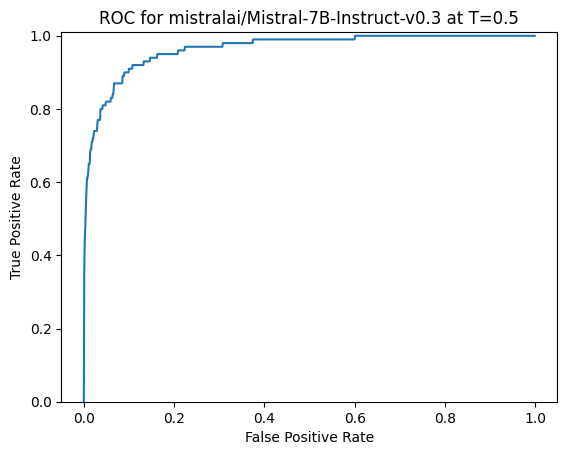

In [21]:
import numpy as np
import matplotlib.pyplot as plt
eli5_freq_scores = frequentist_score(
    padded_eli5_g_values.cpu().numpy(), padded_eli5_combined_mask.cpu().numpy()
)
POINT_COUNT = 1000
fprs = np.array(range(POINT_COUNT)) * (1/POINT_COUNT)
tprs = [(np.sum(-eli5_freq_scores <= fpr) / len(eli5_freq_scores)) for fpr in fprs]
plt.plot(fprs, tprs)
plt.title(f"ROC for {MODEL_NAME.value} at T={TEMPERATURE}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim(0, 1.01)

Text(0, 0.5, 'TPR@FPR=1%')

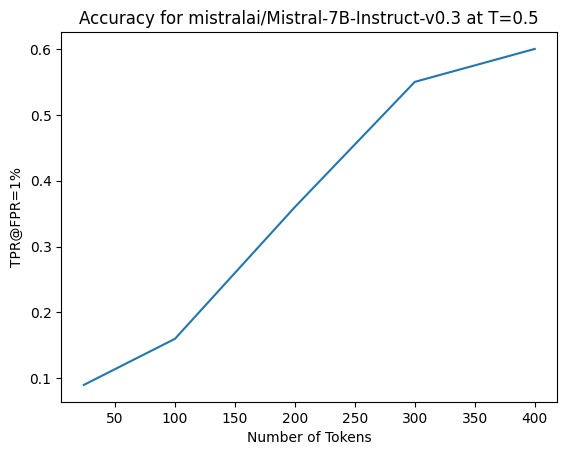

In [22]:
token_counts = [24, 100, 200, 300, 400]
accs = []
for token_count in token_counts:
  freq_scores = frequentist_score(padded_eli5_g_values.cpu().numpy()[:,:token_count,:], padded_eli5_combined_mask.cpu().numpy()[:,:token_count])
  acc = np.sum(-freq_scores <= 0.01) / len(freq_scores)
  accs.append(acc)
plt.plot(token_counts, accs)
plt.title(f"Accuracy for {MODEL_NAME.value} at T={TEMPERATURE}")
plt.xlabel("Number of Tokens")
plt.ylabel("TPR@FPR=1%")